<a href="https://colab.research.google.com/github/LuccaRomagnolli/Machine-Learning/blob/main/K-Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Analysis of Traffic Accidents in Chicago Using K-Means 🚗

### Project Summary: Clustering Traffic Accidents in Chicago Using K-Means

This project analyzes traffic accident data in Chicago using the K-Means clustering algorithm to identify geographic patterns, focusing on incidents involving injuries and fatalities.

### Data Source:
The data comes from the City of Chicago’s public dataset “Traffic Crashes - Crashes” via the Socrata Open Data API. It includes crashes from the six months prior to January 15, 2021.

### Key Steps:

- Fetched and combined over 20,000 crash records.

- Cleaned and filtered the data to focus on latitude, longitude, total injuries, and fatalities.

- Visualized crash severity using scatter plots.

- Applied K-Means clustering (k=20) to fatal crash locations.

- Displayed clusters on an interactive map using Folium.

### Tools Used:
* Python,
* Pandas,
* Socrata API,
* Matplotlib,
* Scikit-learn,
* Geopandas,
* Folium.

### Outcome:

The project highlights accident hotspots in Chicago, offering insights that can support traffic safety planning and urban development.

## Libraries needed in the notebook

In [5]:
# Library used to read datasets
# !pip install sodapy 2>&1 >pipsodapy.txt
# # Install geopandas for geo objects support
# !pip install geopandas 2>&1 >pipgeopandas.txt
# # Install folium for map rendering
# !pip install folium 2>&1 >foliumpip.out

# import urllib3, requests, json
import pandas as pd
import numpy as np
import io

# pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
# matplotlib.patches lets us create colored patches, which we can use for legends in plots
import matplotlib.patches as mpatches
%matplotlib inline

from sodapy import Socrata
import geopandas as gp
import folium

## Getting the Data


We'll get the data dynamically using the socrata API. See also [W005-FindingData.ipyng](W005-FindingData.ipyng)

To limit our dataset, we are reading the last 6 months of data.

The dataset attributes include

* alignment  
* beat_of_occurrence  
* crash_date  
* crash_date_est_i  
* crash_day_of_week  
* crash_hour  
* crash_month  
* crash_record_id  
* crash_type  
* damage  
* date_police_notified  
* device_condition  
* dooring_i  
* first_crash_type  
* hit_and_run_i  
* injuries_fatal  
* injuries_incapacitating  
* injuries_no_indication  
* injuries_non_incapacitating  
* injuries_reported_not_evident  
* injuries_total  
* injuries_unknown  
* intersection_related_i  
* lane_cnt  
* latitude  
* lighting_condition  
* location  
* longitude  
* most_severe_injury  
* num_units  
* photos_taken_i  
* posted_speed_limit  
* prim_contributory_cause  
* private_property_i  
* rd_no  
* report_type  
* road_defect  
* roadway_surface_cond  
* sec_contributory_cause  
* statements_taken_i  
* street_direction  
* street_name  
* street_no  
* traffic_control_device  
* trafficway_type  
* weather_condition  
* work_zone_i  
* work_zone_type  
* workers_present_i  

In [6]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

In [7]:
from datetime import date
from dateutil.relativedelta import relativedelta

# If we wanted to do today:
# six_months = (date.today() - relativedelta(months=+6)).strftime('%Y-%m-%d')

# We are using a fix date for future comparisons
six_months = (date(2021,1,15) - relativedelta(months=+6)).strftime('%Y-%m-%d')
where = "crash_date > '{}'".format(six_months)

In [8]:
# https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
crashes_df = pd.DataFrame(client.get("85ca-t3if", where=where, limit=10000))
offset = 10000
result = client.get("85ca-t3if", where=where, offset=offset, limit=10000)

# Use a list to store DataFrames fetched in each iteration
dfs_to_concat = [crashes_df]

while (len(result) > 0) :
    # Append the new DataFrame to the list
    dfs_to_concat.append(pd.DataFrame(result))
    offset += 10000
    result = client.get("85ca-t3if", where=where, offset=offset, limit=10000)

# Concatenate all DataFrames in the list at once
crashes_df = pd.concat(dfs_to_concat, ignore_index=True)

print("Number of records: {}, number of columns: {}".format(crashes_df.shape[0], crashes_df.shape[1]))

Number of records: 530042, number of columns: 48


## Selecting Columns

In this example, we keep it simple and only work with the longitude and latitude.

When using clustering, we are not limited to positions such as longitude and latiutude. We can iuse other attributes. For example, we can look at injuries and fatal injuries for example.

For the clustering to make sense, we need to make sure that all the values are normalized. This way one value does not overwhelm the clustering. More on modeling later.

Here's what we need to do once we selected our columns:

  - Reading the data from Socrata only gives us character strings, we need to convert to the proper types
  - We also need to remove the records that don't have longitude and latitude.
  This demonstrates that we always need to do data cleansing.


In [10]:
# Has to be a better way to do this...
crashes_df = crashes_df[['injuries_fatal','injuries_total','latitude','longitude']]
# convert 'injuries_fatal' and 'injuries_total' to float otherwide, int causes problems.
crashes_df = crashes_df.astype({'injuries_fatal': float, 'injuries_total': float,
                                'latitude': float, 'longitude': float})
crashes_df = crashes_df.dropna()
crashes_df = crashes_df[crashes_df['longitude'] != 0]
crashes_df = crashes_df[crashes_df['latitude'] != 0]

#divide dataset into accident categories: fatal, non-fatal but with injuries, none of the above
killed_df = crashes_df[crashes_df['injuries_fatal']>0]
injured_df = crashes_df[np.logical_and(crashes_df['injuries_total']>0, crashes_df['injuries_fatal']==0)]

killed_or_injured_df = pd.concat([killed_df, injured_df], ignore_index=True)
nothing_df = crashes_df[np.logical_and(crashes_df['injuries_fatal']==0, crashes_df['injuries_total']==0)]

print("Number of records: {}".format(crashes_df.shape[0]))
print("Number of fatal accidents: {}".format(killed_df.shape[0]))
print("Number of injury accidents: {}".format(injured_df.shape[0]))
print("Number of no-injury accidents: {}".format(nothing_df.shape[0]))

crashes_df.describe()

Number of records: 523999
Number of fatal accidents: 646
Number of injury accidents: 80559
Number of no-injury accidents: 442794


,injuries_fatal,injuries_total,latitude,longitude
count,523999.000000,523999.000000,523999.000000,523999.000000
mean,0.001328,0.214834,41.856232,-87.679686
std,0.039100,0.598451,0.086821,0.059509
min,0.000000,0.000000,41.644670,-87.936193
25%,0.000000,0.000000,41.780828,-87.722563
50%,0.000000,0.000000,41.873049,-87.675611
75%,0.000000,0.000000,41.924709,-87.634433
max,3.000000,21.000000,42.022780,-87.524587


## Scatter plot (visualizing)

Create a visualization of the accidents. Note that this is not a map.

Having a graphical representation of our data can give us some insights on how to proceed.

In [12]:
# Use calculated values for the plot limits (border)
minlong = crashes_df['longitude'].min(axis=0) - 0.005
maxlong = crashes_df['longitude'].max(axis=0) + 0.005
minlat = crashes_df['latitude'].min(axis=0) - 0.005
maxlat = crashes_df['latitude'].max(axis=0) + 0.005
print("min, max, longitude, latitude: {}, {}, {}, {}".format(minlong,maxlong,minlat,maxlat))

min, max, longitude, latitude: -87.9411929466, -87.51958738660001, 41.639670132199996, 42.0277798611


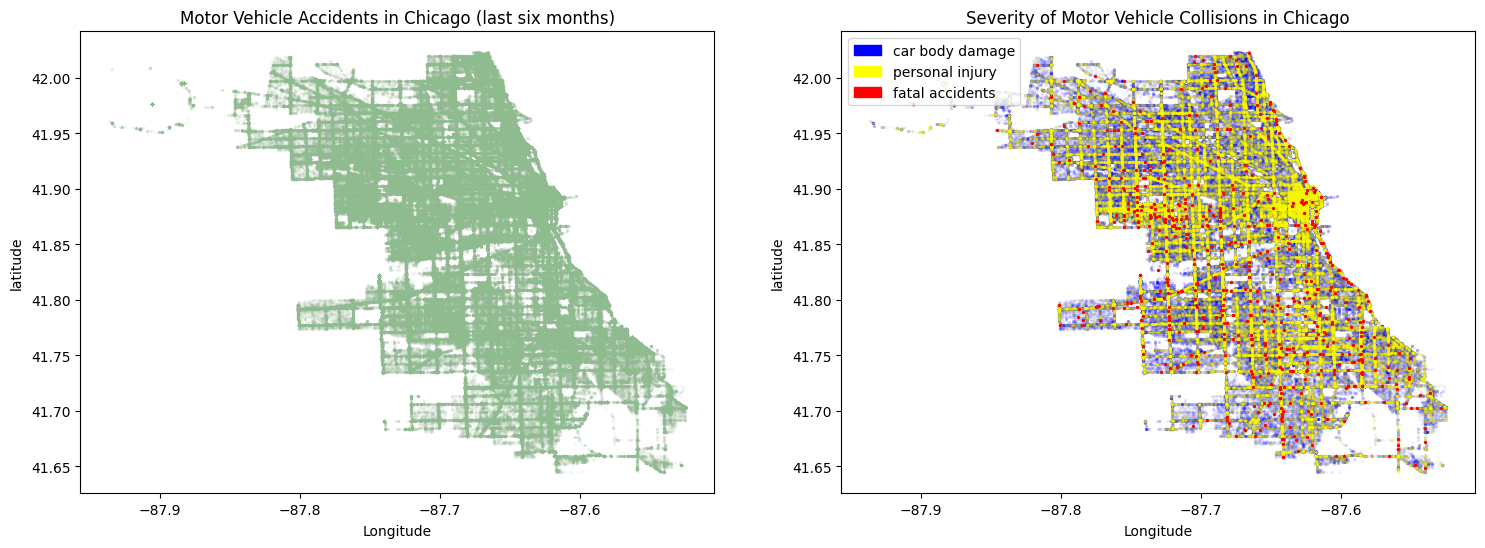

In [13]:
# I've also done subplots in notebook 61
nb_rows = 1
nb_plots = 2

fig, axes = plt.subplots(nrows=nb_rows, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(18)

axes[0].scatter(crashes_df.longitude, crashes_df.latitude, color='darkseagreen', alpha=0.05, s=2)
axes[0].title.set_text('Motor Vehicle Accidents in Chicago (last six months)')
axes[0].set_xlabel('Longitude', labelpad = 5)
axes[0].set_ylabel('latitude', labelpad = 5)


axes[1].scatter(nothing_df.longitude, nothing_df.latitude, color='blue', alpha=0.04, s=2)
axes[1].scatter(injured_df.longitude, injured_df.latitude, color='yellow', alpha=0.12, s=2)
axes[1].scatter(killed_df.longitude, killed_df.latitude, color='red', alpha=1, s=2)

#create legend
blue_patch = mpatches.Patch( label='car body damage', color='blue')
yellow_patch = mpatches.Patch(color='yellow', label='personal injury')
red_patch = mpatches.Patch(color='red', label='lethal accidents')
axes[1].legend([blue_patch, yellow_patch, red_patch],('car body damage', 'personal injury', 'fatal accidents'),
           loc='upper left', prop={'size':10})
axes[1].title.set_text('Severity of Motor Vehicle Collisions in Chicago')
axes[1].set_xlabel('Longitude', labelpad = 5)
axes[1].set_ylabel('latitude', labelpad = 5)
plt.show()


### What do we see?

  - The Chicago area has a lot of accidents and they are all over the place.
  - The first graph shows darket color in areas. This implies more accident density in some place.
  - An overwhelming number of accident do not involve injurues or death.
  - Reducing the opacity (alpha) of each point improved the information proivided by the map.



### Let's see the graph for only injuries and deaths

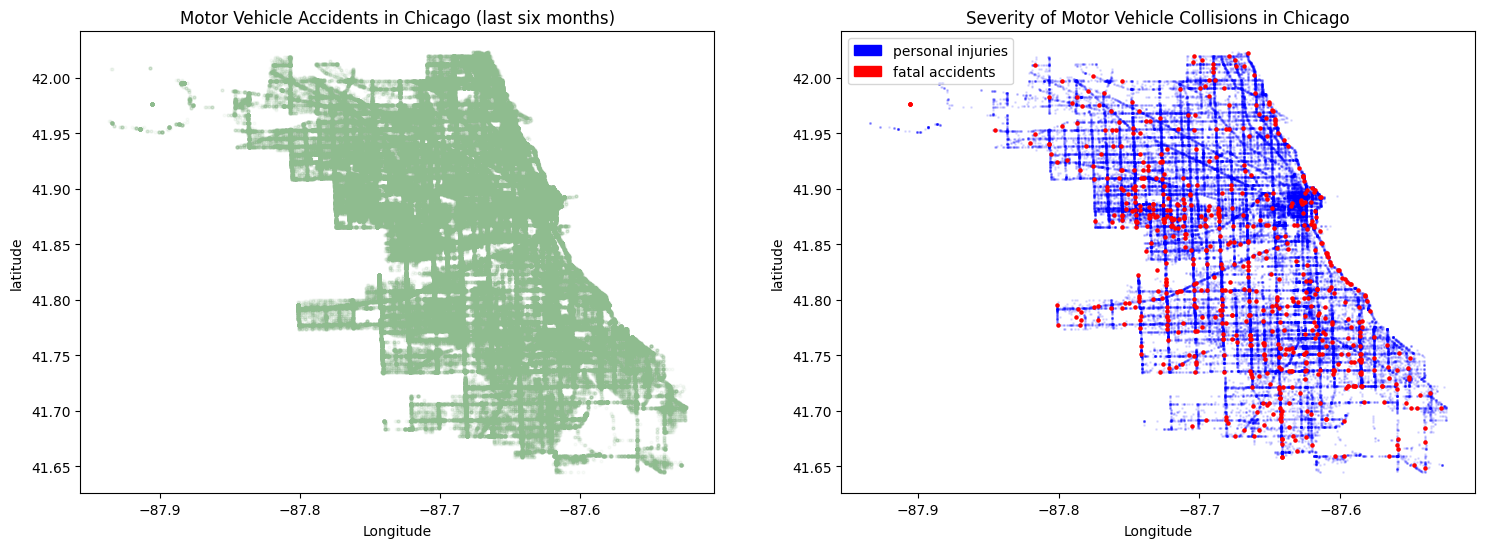

In [14]:


# I've done subplots in notebook 61
nb_rows = 1
nb_plots = 2

fig, axes = plt.subplots(nrows=nb_rows, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(18)

axes[0].scatter(crashes_df.longitude, crashes_df.latitude, alpha=0.05, s=4, color='darkseagreen')
axes[0].title.set_text('Motor Vehicle Accidents in Chicago (last six months)')
axes[0].set_xlabel('Longitude', labelpad = 5)
axes[0].set_ylabel('latitude', labelpad = 5)


axes[1].scatter(injured_df.longitude, injured_df.latitude, alpha=0.1, s=1, color='blue')
axes[1].scatter(killed_df.longitude, killed_df.latitude, color='red', s=5)

#create legend
blue_patch = mpatches.Patch( label='personal injuries', color='blue')
red_patch = mpatches.Patch(color='red', label='lethal accidents')
axes[1].legend([blue_patch, red_patch],('personal injuries', 'fatal accidents'),
           loc='upper left', prop={'size':10})
axes[1].title.set_text('Severity of Motor Vehicle Collisions in Chicago')
axes[1].set_xlabel('Longitude', labelpad = 5)
axes[1].set_ylabel('latitude', labelpad = 5)
plt.show()



## Clustering with K-Means
Apply it only to accidents with fatalities for now.

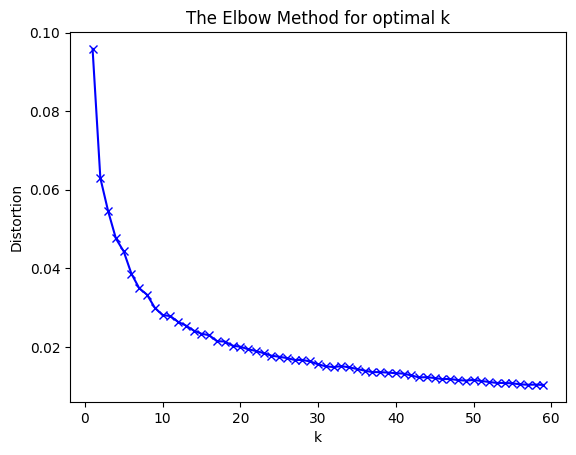

In [15]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

distortions = []
K = range(1,60,1)
df = killed_df[['longitude','latitude']]
for k in K :
    kmeanModel = KMeans(n_clusters=k).fit(df)
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for optimal k')
plt.show()

### Pick 20 as the optimal K for K-Mean cluster

In [18]:
k=20
model = KMeans(n_clusters=k)
kmeans = model.fit(df)
vals=[0] * k
for i in kmeans.labels_ :
    vals[i] = vals[i] + 1
# Distribution between clusters
vals

[19, 38, 40, 41, 36, 20, 42, 69, 28, 44, 18, 46, 37, 24, 22, 34, 43, 4, 30, 11]

### Show the Clusters on map

In [25]:
data_pd = df.copy(deep=True)
data_pd['cgroup'] = kmeans.labels_
data_pd['cnt'] = [1] * kmeans.labels_.shape[0]

geo_gpd = gp.GeoDataFrame(data_pd, geometry=gp.points_from_xy(data_pd.longitude, data_pd.latitude))
#geo_gpd.head(5)

In [24]:
# Create shapes for each cluster
group_gpd = geo_gpd[['cgroup','geometry','cnt']].dissolve(by='cgroup', aggfunc='sum').reset_index()
group2_gpd = gp.GeoDataFrame(group_gpd[['cgroup','cnt']],geometry=group_gpd.geometry.convex_hull)
#group2_gpd.head(5)

In [23]:
latlong = geo_gpd[['latitude','longitude']].mean(axis=0)

chi_map = folium.Map(location=[latlong[0], latlong[1]], zoom_start=10, width="90%", height="90%")

for ix in range(group2_gpd['cnt'].count()) :
    folium.GeoJson(
        group2_gpd.iloc[ix]['geometry'],
        name="cluster-{0}".format(group2_gpd.iloc[ix]['cgroup']),
        tooltip="Cluster: {0}, count: {1}".format(group2_gpd.iloc[ix]['cgroup'],group2_gpd.iloc[ix]['cnt'] )
    ).add_to(chi_map)


folium.LayerControl().add_to(chi_map)
chi_map

<ipython-input-23-48a147b874d1>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chi_map = folium.Map(location=[latlong[0], latlong[1]], zoom_start=10, width="90%", height="90%")
